<h1> I build a Wide and Deep neural network to model part failures in the Bosch dataset. 
    
<h3> This is a test file run on Google Colab for speed, which works on a smaller set of the data, but the code can be adapted to the entire dataset.
    
    
<h3> Training data -- upsampled positive class to reduce class imbalance. 
<h3> Test data -- 50K samples from the actual test set to test the accuracy of the model. 
    
<h3> The code follows the tensorflow tutorials on wide and deep models but adapted to fit this large, and highly sparse data. 

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import shutil
import os
import time

<h4> First specify the numerical columns

In [2]:
# get the names of the column names for the numerical columns
import json
with open('col_names.txt', 'r') as f:
    tot_cols = json.load(f)
    
with open('col_names_deep.txt', 'r') as f:
    deep_cols = json.load(f)

wide_cols = [i for i in tot_cols if i not in deep_cols]

In [35]:
LABEL = len(tot_cols)
NUM_CSV_COLUMNS = tot_cols + [str(LABEL)]
CAT_COLUMNS = [str(i) for i in range(LABEL+1, LABEL+31)]
NUM_DEFAULTS = [tf.constant([0.0], dtype=tf.float64) for m in range(len(NUM_CSV_COLUMNS)-1)] + [tf.constant([0], dtype = tf.int64)]
CAT_DEFAULTS = [['a'] for i in range(30)]
DEFAULTS = NUM_DEFAULTS + CAT_DEFAULTS

In [37]:
len(NUM_CSV_COLUMNS + CAT_COLUMNS) == len(DEFAULTS)

True

<h4> Lets load some data: this data is extremely sparse. Get the dense categorical columns and feed those into the wide model. The deep model should contain the sparse data. Set the threshold value to less than 0.001, so most of the columns are empty 99.99% of the time. So i only pull out 31 columns from the categorical variables

In [98]:
data = pd.read_csv(os.getcwd() + '/FInal_Numeric_Datsets/entire_data_50k_0.csv', names = range(LABEL+31))

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,995,996) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
data.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            989, 990, 991, 992, 993, 994, 995, 996, 997, 998],
           dtype='int64', length=999)

In [ ]:
#understand the sparsity of the categorical data
def get_dense_colums(data, threshold):
    wide_col = []
    deep_col = []
    for column in range(LABEL+1, 3109):
        if len(data[column].value_counts())/data.shape[1] < threshold:
            deep_col.append(column)
        else:
            wide_col.append(column)
    return wide_col, deep_col

In [7]:
# get all the unique keys for the categorical variables
keys = set()
for i in range(LABEL+1, data.shape[1]):
    keys.update(data[i].values.astype(str))

In [13]:
keys

['T48576',
 'T1',
 'T96',
 'T16777248',
 'T-2147482432',
 'T4',
 'T16777557',
 'T3',
 'nan',
 'T1372',
 'T32',
 'T-2147482816',
 'T6',
 'T-2147483648',
 'T1152',
 'T52',
 'T36992',
 'T-21474872',
 'T48',
 'T16',
 'T2',
 'T-2147481664',
 'T-21474825',
 'T8',
 'T56',
 'T492',
 'T65536',
 'T-2147482688',
 'T5',
 'T256',
 'T512',
 'T7',
 'T16777232',
 'T128']

In [8]:
with open('vocab_list.txt', 'w') as f:
     json.dump(list(keys), f)

In [9]:
import json
with open('vocab_list.txt', 'r') as f:
    keys = json.load(f)

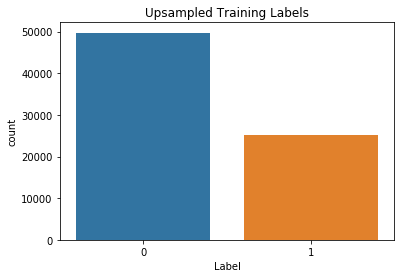

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data[LABEL])
plt.title('Upsampled Training Labels')
plt.xlabel('Label')
plt.show()

<h3> Numerical Feature Engineering: All the numerical columns get put into a wide model. Separate the numerical columns into wide and deep columns. Since I only pulled out 31 categorical columns and they are so sparse to begin with, they should be made DEEP as well.

In [17]:
INPUT_COLUMNS = []
for col in NUM_CSV_COLUMNS:
    INPUT_COLUMNS.append(tf.feature_column.numeric_column(col))
    
WIDE_NUM_COLS = []
for col in wide_cols:
    WIDE_NUM_COLS.append(tf.feature_column.numeric_column(col))
    

DEEP_NUM_COLS = []
for col in deep_cols:
    DEEP_NUM_COLS.append(tf.feature_column.numeric_column(col))

In [18]:
#wide_cat_colnames, deep_cat_colnames = get_dense_colums(data, 0.001)

In [ ]:
#print("Num of Wide Columns = {}, Num of Deep Columns = {}".format(len(WIDE_CAT_COLS), len(DEEP_CAT_COLS)))
#wide_cat_colnames

In [38]:
#WIDE_CAT_COLS = []
#for col in wide_cat_colnames:
#        my_col = tf.feature_column.categorical_column_with_vocabulary_list(str(col), keys)
#        WIDE_CAT_COLS.append(tf.feature_column.indicator_column(my_col))
DEEP_CAT_COLS = []
for col in CAT_COLUMNS:
    my_col = tf.feature_column.categorical_column_with_vocabulary_list(str(col), keys)
    DEEP_CAT_COLS.append(tf.feature_column.embedding_column(my_col, 8))

In [39]:
WIDE_COLS = WIDE_NUM_COLS
DEEP_COLS = DEEP_NUM_COLS+ DEEP_CAT_COLS

In [ ]:
# Let's write a function which does all this for us
def make_cat_feature_cols(data, threshold):
    wide_cat_colnames, deep_cat_colnames = get_dense_colums(data, 0.001)
    
    WIDE_CAT_COLS = []
    for col in wide_cat_colnames:
        my_col = tf.feature_column.categorical_column_with_vocabulary_list(str(col), keys)
        WIDE_CAT_COLS.append(tf.feature_column.indicator_column(my_col))

    DEEP_CAT_COLS = []
    for col in deep_cat_colnames:
        my_col = tf.feature_column.categorical_column_with_vocabulary_list(str(col), keys)
        DEEP_CAT_COLS.append(tf.feature_column.embedding_column(my_col, 8))
    
    return WIDE_CAT_COLS, DEEP_CAT_COLS

In [ ]:
def make_more_features(feats):
    ''' leave this alone for now -- make crossed columns etc'''
    return feats

<h3> Model

In [113]:
if os.path.exists("./tmp/WDNN_model_entire"):
    shutil.rmtree("./tmp/WDNN_model_entire")
    model_wdnn_entire_dir = "./tmp/WDNN_model_entire"
else:
    model_wdnn_entire_dir = "./tmp/WDNN_model_entire"  

config = tf.estimator.RunConfig(tf_random_seed = 42,
                                save_checkpoints_steps=250,
                                save_checkpoints_secs=None,
                                save_summary_steps=500
    )

model = tf.estimator.DNNLinearCombinedClassifier(
    model_dir=model_wdnn_entire_dir,
    linear_feature_columns=WIDE_COLS,
    dnn_feature_columns=DEEP_COLS,
    dnn_hidden_units=[128, 64, 32],
    n_classes=2,
    loss_reduction=tf.losses.Reduction.MEAN,
    config=config)

INFO:tensorflow:Using config: {'_model_dir': './tmp/WDNN_model_entire', '_tf_random_seed': 42, '_save_summary_steps': 500, '_save_checkpoints_steps': 250, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1368da358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [114]:
PATH  = os.getcwd() + '/FInal_Numeric_Datsets/entire_data_50k_*.csv'
TEST_PATH = os.getcwd() + '/FInal_Numeric_Datsets/test_entire_data_50k_0.csv'
BATCH_SIZE = 100

def read_dataset(filename, mode, batch_size = BATCH_SIZE):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.decode_csv(value_column, record_defaults = DEFAULTS)
            features = dict(zip(NUM_CSV_COLUMNS + CAT_COLUMNS, columns))
            label = features.pop(str(LABEL))
            return features, label

    # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename)

    # Create dataset from file list
        dataset = tf.data.TextLineDataset(file_list)
        dataset = dataset.map(decode_csv)
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 10*batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs).batch(batch_size)
        return dataset.make_one_shot_iterator().get_next()
    return _input_fn
    

def get_train():
    return read_dataset(PATH, mode = tf.estimator.ModeKeys.TRAIN)

def get_valid():
    return read_dataset(TEST_PATH, mode = tf.estimator.ModeKeys.EVAL)


In [115]:
#LEN_DATA = 75000*19
#N_EPOCHS = 10
#max_steps = LEN_DATA*N_EPOCHS//BATCH_SIZE
start = time.time()
model.train(input_fn = get_train(), max_steps = 5000)
end = time.time()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./tmp/WDNN_model_entire/model.ckpt.
INFO:tensorflow:loss = 0.6974934, step = 1
INFO:tensorflow:global_step/sec: 2.70628
INFO:tensorflow:loss = 0.6784006, step = 101 (36.952 sec)


KeyboardInterrupt: 

In [106]:
#from google.datalab.ml import TensorBoard as tb
#tb.start(model_wdnn_entire_dir)

In [105]:
!tensorboard --logdir=model_wdnn_entire_dir

TensorBoard 1.12.0 at http://WKMUS9544803:6006 (Press CTRL+C to quit)
^C


In [ ]:
# Test the model on the test set
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, roc_curve, recall_score, precision_score, matthews_corrcoef

In [108]:
def calculate(prediction, LABEL):
    arr = {"accuracy": accuracy_score(LABEL, prediction),
           "Confusion_Matrix": confusion_matrix(LABEL, prediction),
           "F1 score": f1_score(LABEL,prediction),
           "Recall Score": recall_score(LABEL, prediction),
           "Precision Score": precision_score(LABEL, prediction)
           }
    return arr

def get_predictions(model, name, input_fn):
    y = model.predict(input_fn = input_fn)
    predictions = list(y)
    pred1=pd.DataFrame(data=predictions)
    prediction=pd.DataFrame(data=pred1['class_ids'])
    pred=[]
    for row in prediction["class_ids"]:
        pred.append(row[0])
    return pd.DataFrame(pred)

In [66]:
get_test_data = pd.read_csv(TEST_PATH, names = range(0, 999))

In [92]:
TEST_LABEL = get_test_data[LABEL]

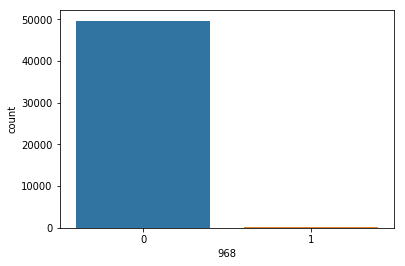

In [94]:
# highly imbalanced test set
sns.countplot(TEST_LABEL)

In [55]:
predicted_labels = get_predictions(model, 'Validation', get_valid())

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/WDNN_model_entire/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [117]:
#train_predicted_labels = get_predictions(model, 'Training', get_train())

In [ ]:
TRAIN_LABEL = pd.read_csv(TEST_PATH, names = range(0, 999))[LABEL]
predictions = calculate(train_predicted_labels, TRAIN_LABEL)
predictions 

In [116]:
predictions = calculate(predicted_labels, TEST_LABEL)
predictions

{'accuracy': 0.9938, 'Confusion_Matrix': array([[49690,     3],
        [  307,     0]]), 'F1 score': 0.0, 'Recall Score': 0.0, 'Precision Score': 0.0}